# Задание 1 (1 балл)

Если разбить поисковые запросы пользователей в РФ по тематикам, то можно выделить несколько кластеров, запросы в которых имеют похожий смысл или тему. В файле `searches.csv` - 6 временных рядов, соответствующих кластерам:

    1. Коронавирус
    2. Отели за границей
    3. Школьные задания
    4. Подарки и поздравления
    5. Спортивные события
    6. Музыка

Определите, какой временной ряд относится к какому кластеру.

Дайте ответ для всех кластеров в формате "кластерX - `<название>`, потому что ... (ваши наблюдения и выводы на основе временного ряда)".

Ответы без обоснования не будут приняты.


In [ ]:
from prophet import Prophet

In [ ]:
import pandas as pd

searches_df = pd.read_csv('searches.csv', parse_dates=['ds'])
searches_df.head()

,ds,кластер1,кластер2,кластер3,кластер4,кластер5,кластер6
0,2019-01-01,299036,1493286,11268577,50492,18596,599268
1,2019-01-02,228190,818971,8629779,57169,25282,952299
2,2019-01-03,297875,734393,7828308,61336,25863,1176552
3,2019-01-04,211296,742071,7542338,64927,27730,1304149
4,2019-01-05,270611,828797,7618576,62939,27709,1419539


In [ ]:
import pandas as pd
import plotly.graph_objects as go

data = pd.read_csv('searches.csv')
data['ds'] = pd.to_datetime(data['ds'])
monthly_data = data.groupby(data['ds'].dt.to_period('M')).sum()
monthly_data.index = monthly_data.index.astype(str)

fig = go.Figure()

for column in monthly_data.columns:
    fig.add_trace(go.Scatter(
        x=monthly_data.index,
        y=monthly_data[column],
        name=f'{column}',
        mode='lines'
    ))

fig.update_layout(
    title='График суммы запросов по кластерам',
    xaxis_title='Месяц',
    yaxis_title='Сумма запросов'
)

fig.show()

<ipython-input-192-0bbf5a27a5ba>:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



кластер1 - Спортивные события - методом исключения (все, кроме 1 и 5 +- очевидно, а по ощущениям в среднем количество запросов, связанных с спортом, должно быть больше, чем про отели за границей)

кластер2 - Подарки и поздравления, тк количество запросов растет достигает пика каждый декабрь и февраль-март

кластер3 - Музыка, тк количество запросов имеет восходящий тренд на всех данных, и из всех кластеров музыка меньше всего подвержена внешним изменениям

калстер4 - Коронавирус, тк виден резкий рост количества запросов с января 2020-го

калстер5 - Отели за границей, тк по сравнению с остальными кластерами имеет наименьшее количество запросов на протяжении всего времени, и после января 2020-го виден резкий спад (связано с коронавирусом)

калстер6 - Школьные задания, тк количество запросов достигает минимумов каждое лето, а так же был резкий рост в апреле 2020, когда школьников закрыли на дистант

# Задание 2 (4 балла)


## Задача

Вам дана небольшая выборка поисковых запросов, связанных с поиском работм. Запросы разбиты на подкатегории 1, 2, 3, 4, 5, 6, 7 и 8.
Вам нужно сделать подневный прогноз **суммы** поисковых запросов с учётом трендов, сезонности, праздников и аномалий. При этом нужно продемонстрировать качество модели.

Представьте, что сегодня 1 июля 2021 года, и вам нужно спрогнозировать количество запросов до конца 2021 года.

Прогноз можно строить в Excel, Jupyter Notebook или другими знакомыми инструментами. Главное, чтобы расчёт мог воспроизвести другой человек.

## Данные



Для того, чтобы не только сделать прогноз, но и проверить качество модели, данные разбиты на три файла:

`train.csv` - обучающая выборка с 2017-01-01 по 2020-12-31

`test.csv` - тестовая выборка с 2021-01-01 по 2021-06-30

`val.csv` - валидационная выборка с 2021-07-01 по 2021-12-31. **Для чистоты эксперимента не смотрите его пока что, это данные о будущем, которое хотим предсказать.**

Их назначение будет объяснено позже.

## Оценка качества

Для оценки качества прогнозных моделей проведём эксперимент: скроем от модели часть известных нам данных, построим прогноз, а затем проверим, насколько хорошо он попадает в факт.

Для оценки качества моделей будем использовать метрику [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) по дням: $\text{MAPE} = 100\% \cdot \dfrac{1}{n}\sum_{i=1}^n  \left|\dfrac{факт_i - прогноз_i}{факт_i}\right| $

Например, если нужно рассчитать MAPE за первые 6 месяцев 2021 года (181 день), получим формулу $\text{MAPE} = 100\% \cdot \dfrac{1}{181}\sum_{i=1}^{181}  \left|\dfrac{факт_i - прогноз_i}{факт_i}\right| $


In [ ]:
# Пример функции MAPE, которая принимает на вход два списка с значениями
def mape(fact_list, forecast_list):
    errors = []

    for f, p in zip(fact_list, forecast_list):
        e = abs((f - p) / f)
        errors.append(e)

    return 100.0 * sum(errors) / len(errors)

mape([1, 2, 3, 4], [0.5, 1.5, 3, 4.5])

21.875

## 2.1. Базовый прогноз (1 балл)
1. Откройте обучающую выборку из файла `train.csv` в Excel или загрузите в pandas DataFrame. Модели должны обучаться только на ней
2. Постройте график временного ряда суммы поисковых запросов
3. Постройте прогноз этого ряда до конца 2021 года любым удобным вам способом (например, взяв код или формулу из лекции) **без** очистки данных, подбора параметров модели, учёта праздников и пр.
4. Прочитайте тестовые данные из файла `test.csv` и посчитайте ошибку прогноза (MAPE) на данных за первое полугодие 2021 года. Назовём это значение ошибки `mape1`

In [ ]:
train_df = pd.read_csv('train.csv', parse_dates=['ds'])
train_df.head()

,ds,1,2,3,4,5,6,7,8
0,2017-01-01,8061,10075,20735,8641,3414,39,2343,11229
1,2017-01-02,13243,15663,33827,18966,5900,61,4213,14216
2,2017-01-03,16230,18959,38730,24648,7560,65,5874,17375
3,2017-01-04,18671,21144,42381,29907,9394,69,8042,19965
4,2017-01-05,20471,23040,43880,32436,10076,72,8731,20599


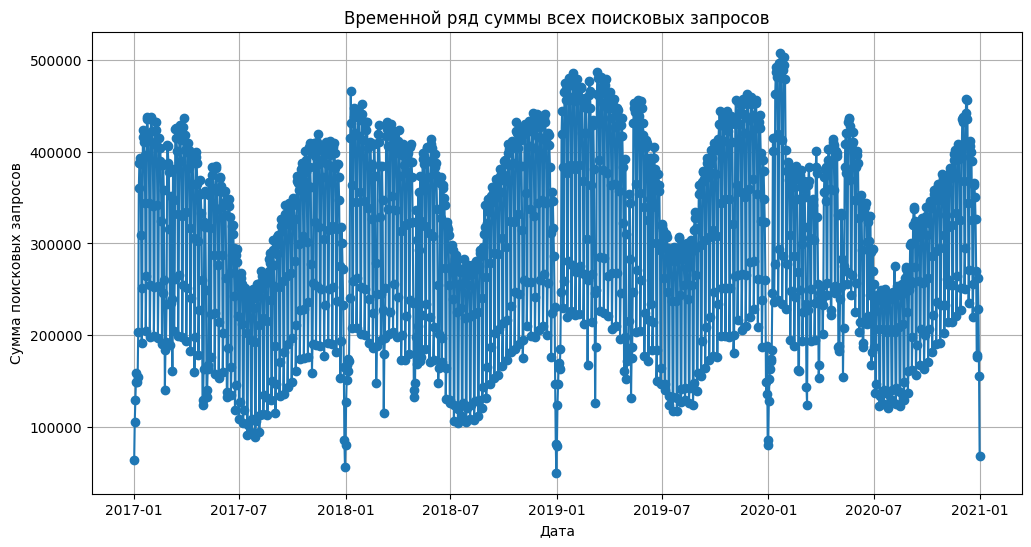

In [ ]:
train_sum_df = train_df[['ds', '1', '2', '3', '4', '5', '6', '7', '8']]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
train_sum_df['sum'] = train_sum_df.drop('ds', axis=1).sum(axis=1)
plt.plot(train_sum_df['ds'], train_sum_df['sum'], marker='o')
plt.xlabel('Дата')
plt.ylabel('Сумма поисковых запросов')
plt.title('Временной ряд суммы всех поисковых запросов')
plt.grid(True)
plt.show()


In [ ]:
# постройте прогноз этого суммарного ряда

model = Prophet()
train_data = train_sum_df.rename(columns={'ds': 'ds', 'sum': 'y'})
model.fit(train_data)

future_dates = model.make_future_dataframe(periods=365, include_history=False)
forecast_df_1 = model.predict(future_dates)[['ds', 'yhat']]

forecast_df_1

In [ ]:
test_df = pd.read_csv('test.csv', parse_dates=['ds'])
test_df.head()

,ds,1,2,3,4,5,6,7,8
0,2021-01-01,15721,26737,22323,6795,4608,54,5080,0
1,2021-01-02,22581,42605,33369,14446,7526,77,7141,0
2,2021-01-03,28147,42337,38091,18697,9639,89,8755,0
3,2021-01-04,30981,45813,39446,23713,11766,92,12895,0
4,2021-01-05,33250,45727,41607,25525,12616,96,13744,0


In [ ]:
# сумма всех поисков по дням из тестовой выборки
test_sum_df = test_df[['ds', '1', '2', '3', '4', '5', '6', '7', '8']]
test_sum_df['sum'] = test_sum_df.drop('ds', axis=1).sum(axis=1)

# посчитайте ошибку

mape1 = mape(test_sum_df['sum'], forecast_df_1['yhat'])
mape1

13.782042914850779

## 2.2. Декомпозиция (1 балл)

Давайте проверим, получится ли модель точнее, если мы спрогнозируем сначала поиски по категориям, а затем суммируем.

5. Посмотрите категории поисковых запросов и определите, стоит ли все временные ряды прогнозировать независимо, или часть из них стоит сгруппировать в более крупные сущности (например, из 8 временных рядов можно получить 4). Почему?
6. Постройте прогнозы по исходным или сгруппированным временным рядам (так же **без** предобработки данных), посчитайте MAPE для суммы всех поисков. Назовём её `mape2`

Задание считается выполненным, если у вас есть прогноз, есть **минимум 2 группы** запросов и вы **объяснили**, почему объединили данные именно так (если объединяли) или почему не стали объединять.

In [ ]:
# сгруппируйте категории запросов, если нужно. Почему именно так?
train_df = pd.read_csv('train.csv', parse_dates=['ds'])
categories = train_df.columns[1:]
categories

Index(['1', '2', '3', '4', '5', '6', '7', '8'], dtype='object')

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

for category in categories:
    fig.add_trace(go.Scatter(x=train_df['ds'], y=train_df[category], name=category))

fig.update_layout(
    xaxis=dict(title='Дата'),
    yaxis=dict(title='Сумма поисковых запросов'),
    title='График суммы поисковых запросов для каждой категории'
)

fig.show()

In [ ]:
# постройте прогноз по категориям
forecast_df_2 = pd.DataFrame(columns=['ds'])

groups = [['1', '2', '3', '5'], ['7'], ['8'], ['4'], ['6']]

for i, group in enumerate(groups):
    group_train_data = train_df[['ds'] + group]
    group_train_data['sum'] = group_train_data.drop('ds', axis=1).sum(axis=1)
    group_train_data = group_train_data.rename(columns={'ds': 'ds','sum': 'y'})
    model = Prophet()
    model.fit(group_train_data)
    future_dates = model.make_future_dataframe(periods=365, include_history=False)
    forecast = model.predict(future_dates)
    forecast_df_2 = pd.concat([forecast_df_2, forecast[['ds', 'yhat']].rename(columns={'ds': f'ds_{i+1}', 'yhat': f'yhat_{i+1}'})], axis=1)

forecast_df_2['sum'] = forecast_df_2.drop('ds', axis=1).sum(axis=1)

In [ ]:
forecast_df_2.head()

,ds,ds_1,yhat_1,ds_2,yhat_2,ds_3,yhat_3,ds_4,yhat_4,ds_5,yhat_5,sum
0,NaN,2021-01-01,150177.504416,2021-01-01,24275.159345,2021-01-01,-19603.702242,2021-01-01,29306.730120,2021-01-01,59.644869,184215.336508
1,NaN,2021-01-02,97772.044540,2021-01-02,-1786.632106,2021-01-02,-49293.329904,2021-01-02,20616.198354,2021-01-02,54.876620,67363.157503
2,NaN,2021-01-03,120175.153654,2021-01-03,-1386.273883,2021-01-03,-47947.337386,2021-01-03,35234.760484,2021-01-03,71.280924,106147.583794
3,NaN,2021-01-04,187963.752307,2021-01-04,29360.264192,2021-01-04,-10814.369864,2021-01-04,48873.827737,2021-01-04,81.817699,255465.292071
4,NaN,2021-01-05,197066.734858,2021-01-05,32835.905546,2021-01-05,-7066.153112,2021-01-05,50207.274556,2021-01-05,82.339101,273126.100949


In [ ]:
# посчитайте ошибку по данным из test_sum_df

mape2 = mape(test_sum_df['sum'], forecast_df_2['sum'])
mape2

13.51199133263492

Я сделал первую группу, ориентируясь, что ряды для 1,2,3,5 похожи, а остальные выделил в отдельные группы, потому что ряды для этих категорий не похожи на остальные ряды

## 2.3. Улучшение модели (1 балл)

7. Для каждой группы из предыдущего задания постройте графики с фактом (train + test) и прогнозом, визуально оцените качество прогноза
8. Найдите недостатки, очистите временные ряды от аномалий или обновите параметры модели. Учтите праздники, если позволяет модель. Увеличить точность может использование не-статистического метода для какого-либо из рядов
9. Сделайте прогноз и замерьте качество на суммарных поисках, назовите ошибку `mape3`

Задание считается выполненным, если вы получили `mape3 < mape2` и `mape3 < mape1`, а прогноз №3 на весь 2021 год выглядит визуально адекватным

In [ ]:
import plotly.graph_objects as go

for i, group in enumerate(groups):
    group_fact = train_df[['ds'] + group].append(test_df[['ds'] + group])
    group_forecast = forecast_df_2[[f'ds_{i+1}', f'yhat_{i+1}']]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=group_fact['ds'], y=group_fact.sum(axis=1), name='Факт'))
    fig.add_trace(go.Scatter(x=group_forecast[f'ds_{i+1}'], y=group_forecast[f'yhat_{i+1}'], name='Прогноз'))
    fig.update_layout(title=f'Группа {i+1}', xaxis_title='Дата', yaxis_title='Сумма запросов')
    fig.show()

<ipython-input-204-7f06cd437b01>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-204-7f06cd437b01>:8: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



<ipython-input-204-7f06cd437b01>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-204-7f06cd437b01>:8: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



<ipython-input-204-7f06cd437b01>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-204-7f06cd437b01>:8: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



<ipython-input-204-7f06cd437b01>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-204-7f06cd437b01>:8: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



<ipython-input-204-7f06cd437b01>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-204-7f06cd437b01>:8: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



Визуально прогнозы верно угадывают тренды для вех групп, кроме группы, в которой количество запросов равно 0 с некоторого момента

In [ ]:
# чтобы сравнить каждую группу с тестовой выборкой, нужно так же сгруппировать данные в ней
test_df = pd.read_csv('test.csv', parse_dates=['ds'])

# факт для графиков
train_and_test_df = pd.concat([test_df, train_df])
train_and_test_df.sample(5)

,ds,1,2,3,4,5,6,7,8
282,2017-10-10,58713,53029,55372,65487,27926,86,42291,70628
929,2019-07-19,36446,46369,38796,12113,15805,98,35308,52708
1067,2019-12-04,75527,78555,57439,65798,39996,112,51799,83627
819,2019-03-31,43052,46855,52438,53882,22019,131,15424,30203
283,2017-10-11,58083,52633,54599,64068,27363,85,41655,67702


In [ ]:
# постройте прогноз по очищенным категориям запросов

train_df = pd.read_csv('train.csv', parse_dates=['ds'])
forecast_df_3 = pd.DataFrame(columns=['ds'])

groups = [['1', '2', '3', '5'], ['7'], ['8'], ['4'], ['6']]

for i, group in enumerate(groups):
    group_train_data = train_df[['ds'] + group]
    group_train_data['sum'] = group_train_data.drop('ds', axis=1).sum(axis=1)
    group_train_data = group_train_data.rename(columns={'ds': 'ds','sum': 'y'})
    # теперь учитываю праздники
    model = Prophet(seasonality_mode='multiplicative', holidays_prior_scale=0.02, yearly_seasonality=15)
    model.add_country_holidays(country_name='RU')
    model.fit(group_train_data)
    future_dates = model.make_future_dataframe(periods=365, include_history=False)
    forecast = model.predict(future_dates)
    forecast_df_3 = pd.concat([forecast_df_3, forecast[['ds', 'yhat']].rename(columns={'ds': f'ds_{i+1}', 'yhat': f'yhat_{i+1}'})], axis=1)

# добавляю ограничение, что кол-во запросов > 0
forecast_df_3['yhat_3'] = forecast_df_3['yhat_3'].clip(lower=0)
forecast_df_3['sum'] = forecast_df_3.drop('ds', axis=1).sum(axis=1)

In [ ]:
# посчитайте ошибку по данным из test_sum_df

mape3 = mape(test_sum_df['sum'], forecast_df_3['sum'])
mape1, mape2, mape3

(13.782042914850779, 13.51199133263492, 13.064807432323207)

In [ ]:
import plotly.graph_objects as go

for i, group in enumerate(groups):
    group_fact = train_df[['ds'] + group].append(test_df[['ds'] + group])
    group_forecast = forecast_df_3[[f'ds_{i+1}', f'yhat_{i+1}']]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=group_fact['ds'], y=group_fact.sum(axis=1), name='Факт'))
    fig.add_trace(go.Scatter(x=group_forecast[f'ds_{i+1}'], y=group_forecast[f'yhat_{i+1}'], name='Прогноз'))
    fig.update_layout(title=f'Группа {i+1}', xaxis_title='Дата', yaxis_title='Сумма запросов')
    fig.show()

<ipython-input-208-f07e12ff38ab>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-208-f07e12ff38ab>:8: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



<ipython-input-208-f07e12ff38ab>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-208-f07e12ff38ab>:8: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



<ipython-input-208-f07e12ff38ab>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-208-f07e12ff38ab>:8: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



<ipython-input-208-f07e12ff38ab>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-208-f07e12ff38ab>:8: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



<ipython-input-208-f07e12ff38ab>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-208-f07e12ff38ab>:8: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



## 2.4 Валидация модели (1 балл)

Вы обучали модель на обучающей выборке (train) и корректировали модель, основываясь на ошибке на тестовой выборке (test). Если при этом не оценивать прогноз визуально, модель может "[переобучиться](https://neerc.ifmo.ru/wiki/index.php?title=Переобучение)". В этом случае она будет хорошо предсказывать первое полугодие 2021, а другие периоды - плохо.

Давайте проверим, смогла ли модель понять общие зависимости в данных или переобучилась. Для этого нужно посчитать ошибку на `val.csv` (2021-06-01 - 2021-12-31) для всех моделей.

Задание считается выполненным, если корректно посчитана ошибка на валидационной выборке и построен итоговый график с фактом и прогнозами.

In [ ]:
val_df = pd.read_csv('val.csv', parse_dates=['ds'])
val_df.head()

,ds,1,2,3,4,5,6,7,8
0,2021-07-01,62766,58049,31976,27163,18777,79,42951,0
1,2021-07-02,54381,53112,28523,21717,17004,69,35499,0
2,2021-07-03,34160,36569,24154,11258,9027,67,9524,0
3,2021-07-04,36378,38771,28183,13988,9564,79,10200,0
4,2021-07-05,58207,59820,33812,22573,17787,86,40220,0


In [ ]:
# сумма всех рядов
val_sum_df = val_df[['ds', '1', '2', '3', '4', '5', '6', '7', '8']].sum(axis=1)
val_sum_df.head()

<ipython-input-210-a912927d9a63>:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



0    241761
1    210305
2    124759
3    137163
4    232505
dtype: int64

In [ ]:
# посчитайте ошибку на второе полугодие 2021 года для всех прогнозов

n = len(forecast_df_1) // 2
val_error_1 = mape(val_sum_df, forecast_df_1['yhat'][n:]) # изначальный прогноз суммы
val_error_2 = mape(val_sum_df, forecast_df_2['sum'][n:])  # прогноз, разбитый на подкатегории
val_error_3 = mape(val_sum_df, forecast_df_3['sum'][n:])  # прогноз, разбитый на подкатегории и очищенный от аномалий

val_error_1, val_error_2, val_error_3

(27.846914350649257, 27.537450911630835, 26.853433753060873)

In [ ]:
import plotly.graph_objects as go

for i, group in enumerate(groups):
    group_fact = val_df[['ds'] + group]
    group_forecast = forecast_df_3[[f'ds_{i+1}', f'yhat_{i+1}']][n:]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=group_fact['ds'], y=group_fact.sum(axis=1), name='Факт'))
    fig.add_trace(go.Scatter(x=group_forecast[f'ds_{i+1}'], y=group_forecast[f'yhat_{i+1}'], name='Прогноз'))
    fig.update_layout(title=f'Группа {i+1}', xaxis_title='Дата', yaxis_title='Сумма запросов')
    fig.show()

<ipython-input-212-9d49781937fc>:8: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



<ipython-input-212-9d49781937fc>:8: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



<ipython-input-212-9d49781937fc>:8: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



<ipython-input-212-9d49781937fc>:8: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



<ipython-input-212-9d49781937fc>:8: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



Обычно ошибка на валидационной выборке больше, чем на тестовой, это нормально. Однако, если она **гораздо** (например, в разы) больше ошибки на тестовой выборке, модель переобучилась.

Если ошибка получилась большой, это не критично: у нас не было цели создать идеальный прогноз. Основными критериями при оценивании домашнего задания будут методологически верный подход к построению и визуальная адекватность полученного прогноза

In [ ]:
# постройте при приложите график суммы поисков с фактом (train + test + val) и всеми прогнозами

import plotly.graph_objects as go

all_data = pd.concat([train_df, test_df, val_df])
all_data['sum'] = all_data[['ds', '1', '2', '3', '4', '5', '6', '7', '8']].sum(axis=1)
fig = go.Figure()
fig.add_trace(go.Scatter(x=all_data['ds'], y=all_data['sum'], name='Факт'))

group_forecast = forecast_df_1[['ds', 'yhat']]
fig.add_trace(go.Scatter(x=group_forecast['ds'], y=group_forecast['yhat'], name='Изначальный прогноз'))
group_forecast = forecast_df_2[['ds_1', 'sum']]
fig.add_trace(go.Scatter(x=group_forecast['ds_1'], y=group_forecast['sum'], name='Прогноз, разбитый на подкатегории'))
group_forecast = forecast_df_3[['ds_1', 'sum']]
fig.add_trace(go.Scatter(x=group_forecast['ds_1'], y=group_forecast['sum'], name='Прогноз, разбитый на подкатегории и очищенный от аномалий'))

fig.update_layout(title='Сумма поисковых запросов', xaxis_title='Дата', yaxis_title='Сумма запросов')

fig.show()

<ipython-input-213-0463f1df184d>:6: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

